# **Twitter Sentiment Project**

ULFMiT utilizes inductive transfer learning to apply AMD-LSTM (Merity et al., 2017a), a regular LSTM model with fine-tuned hyperparameters. The base architecture of ULMFiT is ASGD Weight-Dropped LSTM (AWD-LSTM), which implements dropouts, BPTT, and multi-batch encoder. ULFMiT approach is semi-supervised learning since the AWD-LSTM model was pre-trained in an unsupervised manner, but then fine-tuned in a supervised manner. In the Twitter sentiment analysis, I implement the same approach.

We have borrowed the Universal Language Model Fine-tuning (ULFMiT) algorithm originally developed by Jeremy Howard from fast.ai and Sebastian Ruder, and adapted to analyze Twitter airline sentiments. ULFMiT is an effective transfer learning method that can apply existing pre-trained models to any related task in NLP. Our tweets data on airline sentiments are provided by Kaggle challenge.



## Problem Statement:

The project is aiming to analyze what feelings Twitter users expressed by tweeting in February 2015, through creating and tuning an ULMFiT model to correctly classify Twitter airline sentiment data. The result should produce 1 of 3 sentiments (positive, negative, and neutral). The tweets are quantifiable through tokenization to create a numeric representation of words. I will be using the ULFMiT language model provided from the fast.ai library and applying the pre-calculated weights. It will provide a word embedding scheme that aligns with the corpus of airline tweets. In order to capture the meaning in each word, the language model hyperparameters will be tuned and it will lead to a sentiment result. If the model is accurate, my result will match the pre-labeled sentiment.


##  Metrics:


1. F1 Score
Evaluation will be using the F1 score (F1µ) for the three sentiment classes - Positive, Negative and Neutral on the submissions made with predicted class of each sample in the evaluation data set. The calculation of F1 score is the harmonic mean of precision and recall:


2. The error rate = 1 – Accuracy
This is the error rate used in ULMFiT paper. I am able to compare their validation error benchmark on the IMDb sentiment classification task.


#Data Exploration and Pre-processing:

In [0]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt


# Modeling, selection, and evaluation
#!pip install torch
#!pip install torchtext==0.2.3
from fastai.text import *
from fastai import *
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

## Data Exploration:

In [2]:
%matplotlib inline 

# Load csv data and store it in dataframe
url='https://raw.githubusercontent.com/cyu1221/MachineLearningCourse/master/Twitter%20Sentiments/Tweets.csv'
data = pd.read_csv(url)

# Preview the first 10 lines of the loaded data 
data.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


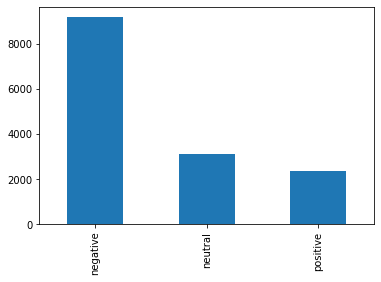

In [3]:
%matplotlib inline
data['airline_sentiment'].value_counts().plot(kind='bar') #plot data by sentiments

* The histograph above shows that there're more negative comments than other categories. It could be that people prefer to tweet about airlines when they are dissatisfied with the airline. 
* From the graph below, United airline, US Airway, and American airline have the most tweets. Virgin America has the least tweets. The total number of positive and neutral tweets are less than 50% of the total tweets per each airlines. However, this is not the case for 3 airlines, Delta, Southwest and Virgin airlines. One reason could be the limited number of tweets in this dataset while most tweets are negative. 

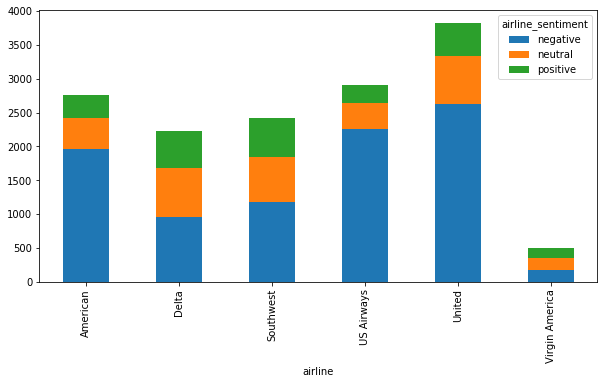

In [4]:
data.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar',figsize=(10, 5),stacked=True)

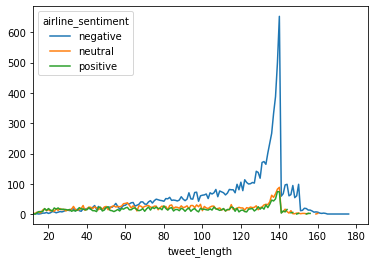

In [5]:
data['tweet_length'] = data['text'].apply(len)
data.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(kind='line', stacked=False)

## Train Test Split:

Filter language to English language only:

In [0]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

Train test split: 30% is testing set. 70% is training set.

In [7]:
df = data[['airline_sentiment', 'text']]
train,test = train_test_split(df, test_size=0.30, random_state=42)
train['text'] = train['text'].apply(clean_ascii)
train.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,airline_sentiment,text
7717,neutral,@JetBlue Re: Flight 8088 SXM&gt;JFK what time ...
13854,negative,@AmericanAir why are you still selling tickets...
11719,negative,@USAirways I have now called 12 times in the l...
239,positive,@VirginAmerica sounds like fun !
8582,neutral,@JetBlue Statement on #Lufthansa Incentive Off...


In [8]:
print(len(train),len(test))

10248 4392


# ULFMiT:


This notebook utilizes ULMFit as implemented in the fastai GitHub repository. 

1. In the ULFMiT package, TextLMDataBunch returns a "Databunch" type of object and helps assembling the raw data to be suitable for NLP. It is used to transform dataframe, csv, tokens, and other data forms into the right form to be used for deep learning. Additionally, The Databunch code includes text manipulation code from the ground up and tokenization. We define a databunch object (data_lm) using training data. 

Source: https://docs.fast.ai/text.data.html#Quickly-assemble-your-data

Tokenization rules Source:https://docs.fast.ai/text.transform.html#Rules

In [9]:
# language model: use 10% as validation set. Language model is trained to guess what the next word is inside a flow of words. 
data_lm = TextLMDataBunch.from_df(train_df = train[:-1024], valid_df=test[-1024:], path="")
data_lm.show_batch()
# Save the language and classifier model data
data_lm.save('data_lm.pkl')
print(len(data_lm.train_ds))

idx,text
0,"i 'm willing to wait on hold , but that 's not an option . xxbos @virginamerica sounds like fun ! xxbos @jetblue xxmaj statement on # xxmaj lufthansa xxmaj incentive xxmaj offer - xxmaj xxunk http : / / t.co / xxunk xxbos @americanair xxmaj thx ! i hope so . xxup iah to xxup dfw to xxup okc has turned out to be a xxup long trip today"
1,"ground staff , it has n't even been taken off the plane yet ! xxbos @usairways i am following you now xxbos @jetblue after my second call to customer service and the xxunk person i talked to , an amazing rep fixed it in about 5 mins ! :) # xxunk xxbos @southwestair so for an extra luggage , it cost $ 75 xxrep 4 ? xxbos @usairways xxmaj will"
2,"10 flights have been delayed . xxmaj huge mistake on my part . xxmaj do n't fly united xxbos @jetblue anything for you . # flyfi http : / / t.co / xxunk xxbos @united even so , change could not be made xxunk instructed to call an xxunk maybe the xxunk should allow agents 2 link passengers ! xxbos @americanair great , thanks ! xxbos @jetblue tells me $"
3,failure in 2015 # unitedairlines xxbos @jetblue 's xxup ceo xxmaj battles to xxmaj appease xxmaj passengers and xxmaj wall xxmaj street - http : / / t.co / e5naxbue4s http : / / t.co / xxunk xxbos @united what 's the best way to get your tickets ? xxmaj print off at home or go to check in desk ? xxbos @united i would take the $ 500 voucher
4,yesterday . i wonder how quickly flight attendants are notified . xxbos @americanair i dmed xxbos @jetblue what is the deal with flt xxunk today ? xxmaj departure keeps changing . xxmaj when is it going why is it so xxmaj late xxmaj flight ? xxbos xxmaj yes but i will nvr fly w / @usairways i missed my con flight bc of a xxunk on xxup xxunk xxmaj could


9224


see chunks of texts in lines

In [10]:
x,y = next(iter(data_lm.train_dl))
example = x[:15,:15].cpu()
texts = pd.DataFrame([data_lm.train_ds.vocab.textify(l).split(' ') for l in example])
texts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,and,i,have,to,work,tomorrow,.,xxbos,@southwestair,i,'m,trying,to,get,home
1,do,.,i,appreciate,the,response,.,xxbos,@southwestair,xxunk,over,two,hours,now,.
2,130,paid,&,&,confirmed,flight,will,now,cost,me,$,xxunk,xxup,cash,xxup
3,you,offered,for,xxup,xxunk,xxup,the,#,xxup,of,xxup,seats,xxup,on,xxup
4,n't,see,my,father,xxunk,they,put,him,in,a,xxunk,xxbos,@united,.,epic
5,i,can,talk,to,?,xxbos,@usairways,they,call,weather,an,act,of,xxmaj,god
6,@united,xxmaj,apart,from,being,on,hold,for,over,2,hours,and,having,talked,to
7,help,?,!,xxbos,@americanair,i,have,been,rebooked,for,the,7,am,flight,.
8,me,to,buy,the,xxunk,tickets,xxbos,@jetblue,figured,it,out,4,flight,xxunk,.
9,bad,weather,",",but,closes,down,customer,relations,center,to,process,refunds,for,xxmaj,cancelled


A total of 5008 vocab were obtained. In NLP tasks, batch size is the first dimension and sequence length is the second because  we don't use the sequence length as the first dimension.

In [11]:
data_lm.vocab.itos[:10]
print(len(data_lm.vocab.itos))

5008


We define an AWD_LSTM learner object (learn_AWD)  that uses the tokenized language model data,  using function language_model_learner. We chose 0.5 (drop_mult) as the multiplier applied to the dropout in the language learner. 

See below for the architecture of AWD_LSTM.


In [12]:
learn_AWD = language_model_learner(data_lm,  AWD_LSTM, drop_mult=0.5)

list(learn_AWD.model.children())

[AWD_LSTM(
   (encoder): Embedding(5008, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(5008, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=5008, bias=True)
   (output_dp): RNNDropout()
 )]

## Learning Rate: 

* Fastai package provides a convenient way to find the optimal learning rate. For our optimization function, the learning rate needs to be at least an order of magnitude below the point at which the loss starts to diverge. Discriminative fine-tuning per the ULMFiT paper, allows different learning rates to be applied to each layer. 
* The learning rate finder train the model over the duration of 1 epoch at a very low learning rate to begin with, and gradually increasing it over time, multiplying it by a given factor at each mini-batch, until it reaches 1, whilst recording the loss at each timestep.

Source function for lr_find: https://github.com/fastai/fastai/blob/050080be574cb1260462bbd03e9600e43e7a54b1/fastai/train.py#L23


In [13]:
learn_AWD.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-02
Min loss divided by 10: 5.25E-02


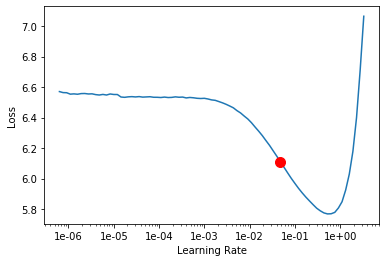

In [14]:
learn_AWD.recorder.plot(suggestion=True)

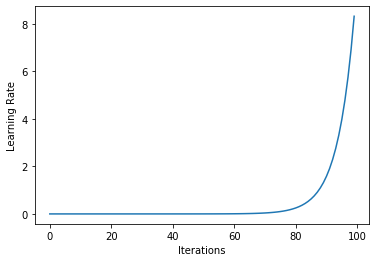

In [15]:
learn_AWD.recorder.plot_lr()

In [0]:
#for GPU mixed precision can be as simple as adding one line of code or enabling a single environment variable, to speed up process
learn_AWD = learn_AWD.to_fp16(clip=0.1)

## Slanted Triangular Learning Rates:

In [17]:
learn_AWD.fit_one_cycle(1, max_lr=1e-3, moms=(0.8,0.7))
learn_AWD.save('fit_head')

epoch,train_loss,valid_loss,accuracy,time
0,6.134846,5.746525,0.163021,00:04


Slated triangular learning rates from ULFMiT. According to the plot below, cut occurs around iteration 15.

Source: Smith’s paper on Cyclical Learning Rates for Training Neural Networks. https://arxiv.org/abs/1506.01186

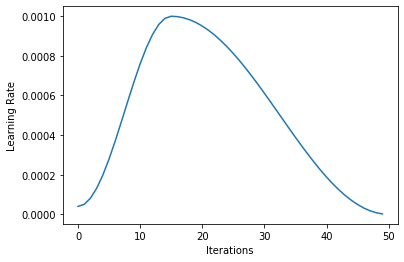

In [18]:
learn_AWD.recorder.plot_lr()

We modified the learning rates and ran the language model fine-tuning step until the validation loss drops to a low value. Next, we fit the model for a few cycles by running 1 epoch. we unfreeze all the layers and then run more epochs for a reasonable time to fine tune until we obtain a low enough validation loss. Since the vocab dictionary is relatively small, we can see validation loss decreasing to a local minimum quickly.


In [19]:
learn_AWD.unfreeze()
learn_AWD.fit_one_cycle(cyc_len=10, max_lr=1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.062055,4.549853,0.224516,00:06
1,4.542558,4.009752,0.261979,00:06
2,4.142228,3.807234,0.282180,00:06
3,3.837845,3.727919,0.287909,00:06
4,3.554187,3.718975,0.287314,00:06
5,3.298807,3.742443,0.287388,00:06
6,3.068625,3.787393,0.288170,00:06
7,2.863219,3.838216,0.287202,00:06
8,2.728090,3.868259,0.285305,00:06
9,2.648600,3.879871,0.284338,00:06


In [0]:
learn_AWD.save('fine_tuned')
# Save the fine-tuned encoder
learn_AWD.save_encoder('fit_enc')

## Classifier:

For classification, we load the data for the forward classifier model using the same language model vocabulary, using TextList data loader. Hyperparameters databunch batch is set to 128, and split (split_by_rand_pct) 10% to validation set and 90% to training set. Similar to learn_AWD learner object, we define a classifier learner (learn_clas) using text_classifier_learner funcion from fast.ai library. 

In [43]:
# load the data for the forward classifier model using the same language model vocabular so that it'll be able to load the encoder 'fit_enc' created above
data_clas = (TextList.from_df(train, vocab=data_lm.train_ds.vocab,cols='text')
                          .split_by_rand_pct(0.1, seed=42) 
                          .label_from_df(cols='airline_sentiment')
                          .databunch(bs=128))

data_clas.save('data_clas.pkl')
data_clas.show_batch()

text,target
xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup san68059 m,negative
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj xxunk xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @united xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and recheck on xxup xxunk ?",neutral
"xxbos @usairways 4 segments , 4 / 4 delayed . xxmaj xxunk > xxup xxunk . xxup xxunk > xxup jan . xxup jan > xxup xxunk . xxup xxunk > xxup xxunk . xxmaj my year off from flying with you guys was the way to go .",negative
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive


In [0]:

learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_clas.load_encoder('fit_enc')
learn_clas.freeze()

In [45]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


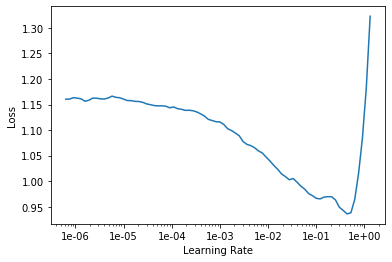

In [46]:
learn_clas.recorder.plot()

## Gradually Unfreezing:

* The paper proposed to gradually unfreeze the model starting from the last layer and fine-tune all unfrozen layers in one epoch. The latter a layer is, the least memory it has compared to other layers. 
* The "gradual unfreezing" technique then freezes the next lower layer and repeats the fine-tuning process until convergence at last iteration. 
* During gradual unfreezing, we apply discriminative fine-tuning on learning rates. 
* The paper recommends to choose the learning rate ηL of the last layer by fine-tuning only the last layer and using ηL−1 = ηL/2.6 as the learning rate for lower layers.

In [0]:
lr=2e-2
learn_clas.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)
learn_clas.save('first')

epoch,train_loss,valid_loss,accuracy,time
0,0.699316,0.587548,0.750977,00:06


In [0]:
lr/=2
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)
learn_clas.save('second')

epoch,train_loss,valid_loss,accuracy,time
0,0.637686,0.550358,0.790039,00:06


In [0]:
lr/=2
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.573802,0.515403,0.797852,00:06


In [0]:
lr/=5
learn_clas.unfreeze()
learn_clas.fit_one_cycle(4, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.503976,0.504744,0.793945,00:06
1,0.490098,0.495602,0.805664,00:06
2,0.472205,0.492248,0.809570,00:06
3,0.446772,0.494754,0.805664,00:06


## Predictions:

*  Cross-tabulate the predictions for each class:


In [0]:
preds_fwd, targets_fwd = learn_clas.get_preds()
predictions_fwd = np.argmax(preds_fwd, axis=1)
pd.crosstab(predictions_fwd, targets_fwd)

col_0,0,1,2
row_0,,,
0,574,64,28
1,42,128,17
2,19,29,123


#Bidirectional Language Model:

In order to apply Bidirectional language model, We'll reverse the words in tweets  form training set. We'll follow the exact same steps we took for language model (data_lm) and language model learner (learn_AWD). 


*   load data from pre-saved 'data_lm.pkl' and reverse it and save it into 'data_lm_back.pkl'
*   apply language model, learning rate finder and train 1 epoch.



## Reverse:

In [0]:
##recall: # language model 
##data_lm = TextLMDataBunch.from_df(train_df = train, valid_df = test, path="")
##Save the language and classifier model data
##data_lm.save('data_lm.pkl')

data_lm_back = load_data('/content/','data_lm.pkl',  backwards=True)
# Save the language and classifier model data
data_lm_back.save('data_lm_back.pkl')
print(len(data_lm_back.train_ds))

9224


## Learning Rate:

In [0]:
learn_AWD_back=language_model_learner(data_lm_back,  AWD_LSTM, drop_mult=0.5)
learn_AWD_back.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-02
Min loss divided by 10: 5.25E-02


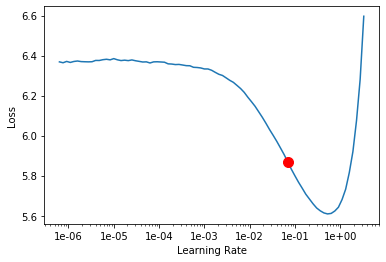

In [0]:
learn_AWD_back.recorder.plot(suggestion=True)

In [0]:
learn_AWD_back.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn_AWD_back.save('fit_head')

epoch,train_loss,valid_loss,accuracy,time
0,4.853065,4.179204,0.287351,00:06


epoch,train_loss,valid_loss,accuracy,time
0,4.186066,4.003013,0.300112,00:06
1,4.025865,3.837646,0.312649,00:06
2,3.871439,3.736770,0.322433,00:06
3,3.714166,3.686411,0.327641,00:06
4,3.554218,3.657007,0.329650,00:06
5,3.410316,3.649693,0.331176,00:06
6,3.276669,3.654272,0.330729,00:06
7,3.171992,3.665735,0.331176,00:06
8,3.094368,3.670538,0.330990,00:06
9,3.075546,3.669675,0.331362,00:06


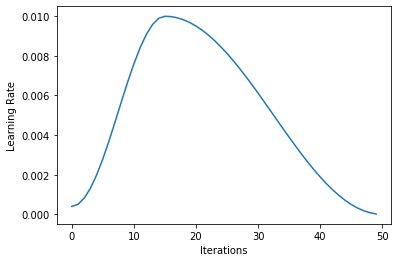

In [0]:
learn_AWD_back.recorder.plot_lr()
learn_AWD_back.unfreeze()
learn_AWD_back.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [0]:
learn_AWD_back.save('fine_tuned')
# Save the fine-tuned encoder
learn_AWD_back.save_encoder('fit_enc')

## Classifier:

In [0]:
# recall: we loaded the data for the forward classifier model using the same language model vocabular so that it'll be able to load the encoder 'fit_enc' created above

data_clas_back=load_data('/content/', 'data_clas.pkl', backwards=True)
data_clas_back.save('bw_data_clas_back.pkl')
data_clas_back.show_batch()

text,target
m san68059 xxup . human xxup a call xxup to xxup number xxup a me xxup give xxup or xxup now xxup me xxup tell xxup ? ? ? bag fucking my is fuck the where xxmaj ! ? ! ? bag xxup fucking xxup my xxup is xxup where xxup @united xxbos,negative
"? xxunk xxup on recheck and bag my collect to have i do xxmaj ? time enough it is xxmaj . m xxunk is lax xxup in time connecting my xxmaj . xxunk xxup - xxunk xxup - lax xxup - sfo xxup flying m i , hi xxmaj @united xxbos",neutral
) : . guys you love xxmaj .. trv to able m i when airline xxmaj my is a.a xxup btw xxmaj .. understand i so .. am xxup this here up gma xxup on was dfw xxup .. aa xxup thanks xxmaj aww xxmaj @americanair xxbos,positive
) : . guys you love xxmaj .. trv to able m i when airline xxmaj my is a.a xxup btw xxmaj .. understand i so .. am xxup this here up gma xxup on was dfw xxup .. aa xxup thanks xxmaj aww xxmaj @americanair xxbos,positive
! bag no still xxmaj . iah xxup to back then and dfw xxup - iah xxup to went bag today xxmaj . iah xxup to went bag xxmaj . aus xxup - dfw xxup - tpa xxup fron yesterday flight a took xxmaj @americanair xxbos,negative


In [0]:
learn_clas_back = text_classifier_learner(data_clas_back, AWD_LSTM, drop_mult=0.5)

In [0]:
learn_clas_back.load_encoder('fit_enc')
learn_clas_back.freeze()
learn_clas_back.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn_clas_back.save('first')

epoch,train_loss,valid_loss,accuracy,time
0,0.700045,0.590025,0.759766,00:07


In [0]:
learn_clas_back.freeze_to(-2)
learn_clas_back.fit_one_cycle(1,slice(1e-2/(2.6**4),1e-2),moms=(0.8, 0.7) )
learn_clas_back.save('second')

epoch,train_loss,valid_loss,accuracy,time
0,0.627393,0.549011,0.784180,00:07


In [0]:
learn_clas_back.freeze_to(-3)

learn_clas_back.fit_one_cycle(1,slice(5e-3/(2.6**4),5e-3),moms=(0.8,0.7) )



epoch,train_loss,valid_loss,accuracy,time
0,0.560708,0.521814,0.795898,00:07


In [0]:
learn_clas_back.unfreeze()
learn_clas_back.fit_one_cycle(3,slice(1e-3/(2.6**4),1e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.501805,0.506121,0.801758,00:08
1,0.478856,0.491060,0.803711,00:08
2,0.461929,0.490978,0.801758,00:08


## Predictions:

In [0]:
preds_back,targets_back=learn_clas_back.get_preds()
predictions_back=np.argmax(preds_back,axis=1)
pd.crosstab(predictions_back,targets_back)

col_0,0,1,2
row_0,,,
0,581,76,34
1,40,123,17
2,14,22,117


## Ensemble Classifier:

For both forward and backward language models, we cross-tabulate the predictions for each class and calculate F1 score and accuracy. Below shows that the forward model has a high accuracy. Ensemble method is to combine the predictions from both models and calculate the average as the final result. It increased accurancy by 0.01.

In [0]:
def f1score(y_true, y_preds):
  f1=sklearn.metrics.f1_score(y_true,y_preds, 
                                labels=None, pos_label=1, average='weighted',sample_weight=None, zero_division='warn')
  return f1

In [0]:
# get combined(mean) predictions
ensemble_preds = (preds_fwd + preds_back)/2
# get combined(mean) accuracy on validation set
print('Ensemble classifier results (validation set): \nValidation accuracy: {:.4f}, Validation error rate: {:.4f}'.format(accuracy(ensemble_preds, targets_fwd), error_rate(ensemble_preds, targets_fwd)))
print('FWD classifier results (validation set): \nValidation accuracy: {:.4f}, Validation error rate: {:.4f}'.format(accuracy(preds_fwd, targets_fwd), error_rate(preds_fwd, targets_fwd)))
print('BACK classifier results (validation set): \nValidation accuracy: {:.4f}, Validation error rate: {:.4f}'.format(accuracy(preds_back, targets_back), error_rate(preds_back, targets_back)))

Ensemble classifier results (validation set): 
Validation accuracy: 0.8135, Validation error rate: 0.1865
FWD classifier results (validation set): 
Validation accuracy: 0.8057, Validation error rate: 0.1943
BACK classifier results (validation set): 
Validation accuracy: 0.8018, Validation error rate: 0.1982


# Evaulate Performance on test set:


*   Apply the learner's predict method to produce our prediction (using learn_clas, learn_clas_back).
*   Calculate F1 score
*   Build Confusion Matrix to analyze the misclassifications under each sentiment

Backward model has more accurate predictions on negative tweets. The forward model  has more accurate predictions on neutral tweets. Both have F1 score 0.818, while the forward model has an error of 0.18 and the backward model has an error of  0.19. The increase of accuracy and F1 score from ensemble model is minimal in this case. 

In [0]:
test['pred_sentiment_fwd'] = test['text'].apply(lambda row: str(learn_clas.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(test['airline_sentiment'], test['pred_sentiment_fwd']))

Test Accuracy:  0.8228597449908925


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
import sklearn
f1_fwd=sklearn.metrics.f1_score(test['airline_sentiment'], test['pred_sentiment_fwd'], 
                                labels=None, pos_label=1, average='weighted',sample_weight=None, zero_division='warn')
print("F1-Score: ",f1_fwd)

F1-Score:  0.8177883314418077


In [0]:
# Confusion matrix plotting adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
   # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

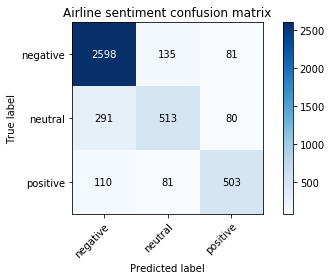

In [0]:
plot_confusion_matrix(test['airline_sentiment'], test['pred_sentiment_fwd'], classes=['negative', 'neutral', 'positive'], title='Airline sentiment confusion matrix')
plt.show()

In [0]:

test['text_reverse'] =  test.text.str.split().apply(lambda x: ' '.join(x[::-1])) #reverse the words

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
test['pred_sentiment_back']=test['text_reverse'].apply(lambda row:str(learn_clas_back.predict(row)[0]))
print("Test Accuracy: ",accuracy_score(test['airline_sentiment'],test['pred_sentiment_back']))

Test Accuracy:  0.808287795992714


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
import sklearn
f1_back=sklearn.metrics.f1_score(test['airline_sentiment'], test['pred_sentiment_back'], 
                                labels=None, pos_label=1, average='weighted',sample_weight=None, zero_division='warn')
print("F1-Score: ",f1_fwd)

F1-Score:  0.8177883314418077


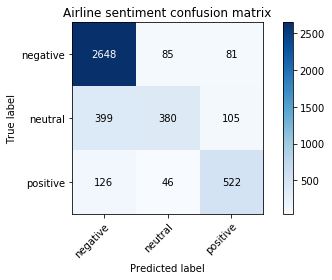

In [0]:
plot_confusion_matrix(test['airline_sentiment'], test['pred_sentiment_back'], classes=['negative', 'neutral', 'positive'], title='Airline sentiment confusion matrix')
plt.show()

# Conclusion:

This project showed a training and classification pipeline for fastai’s framework ULMFiT for evaluating Tweets sentiment. With some data cleaning and hyperparameter tuning, the transfer learning approach using ULMFiT can provide good classification accuracy and F-scores. ULMFiT is flexible and easy to perform classifier training and retraining with a small dataset. However, the language model fine-tuning is expensive and less effective since the language model was pre-trained on text data different from tweets or conversations. 

# Improvements:


Improvements through the following modifications could be implemented in the future.
1. Vocabulary Augmentation: 

Although we implemented transfer learning from pre-trained deep learning model that was pretrained on the Wikipedia dataset, we could augment the dataset with extra Vocabulary. The vocabulary in the training set do not necessarily match the vocabs in our testing set. Specifically, Kaggle Twitter Sentiment140 dataset would be an ideal augment Vocabulary dataset to train our model on. It will allow our model to better understand the structure and specifications of tweets. 
2. Data Collection:

It would be more accurate to train the model on a larger generalized dataset that was collected during a span of time.

3. The Use of Concatenated Pooling:

ULFMiT uses concatenated pooling for large sequences of text. For example, IMDB reviews dataset. However, limited to 140 characters, tweets do not have large sequences. If the use of concatenated pooling can be modified and improved, model performance will increase.


##  Vocabulary Augmentation:

In [26]:
kaggle = pd.read_csv("training.1600000.processed.noemoticon.csv",header=None,encoding = "latin-1")
kaggle.head(5)


,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [27]:
kaggle.columns = ['Target', 'col2',"col3","Stance","col5","Tweet"]
kaggle = kaggle[['Target','Tweet']]
# Clean Data and Remove URL's from the tweets
kaggle['Tweet'] = kaggle['Tweet'].apply(clean_ascii)
kaggle['Tweet'] = kaggle['Tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
kaggle_sub = kaggle.sample(n=200000,random_state=77)
kaggle_sub.head()
#kaggle_sub = kaggle_sub.append(train, ignore_index=True)

,Target,Tweet
134128,0,is terrified about exams
128627,0,I ate waaaay too many cookies this weekend. I...
745050,0,Perfect day.. And i get to spend it at work.
17888,0,Lost my phone in yesterdays rockshow at PESIT ...
1487423,4,Eventful morning/afternoon Now to tackle the ...


In [0]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"} #map target numbers to sentiments.
def decode_sentiment(label):
    return decode_map[int(label)]

In [29]:
%%time
kaggle_sub.Target = kaggle_sub.Target.apply(lambda x: decode_sentiment(x))

CPU times: user 58.1 ms, sys: 543 µs, total: 58.6 ms
Wall time: 63 ms


In [30]:
kaggle_sub.head()
print(len(kaggle_sub))

200000


In [31]:
kaggle_sub.head()
kaggle_sub.rename(columns={'Target': 'airline_sentiment',
                 'Tweet': 'text'}, inplace=True) #rename column
kaggle_sub = kaggle_sub.append(train, ignore_index=True) #append traininh dataset to the kaggle)sub data
print(len(kaggle_sub))
kaggle_sub.reset_index(inplace=True, drop=True)

210248


In [39]:
import pandas as pd 
kaggle_sub['airline_sentiment']=kaggle_sub['airline_sentiment'].str.lower() #lowercase applied to all airline_sentiment
print(len(kaggle_sub))
kaggle_sub.head()

210248


,airline_sentiment,text
0,negative,is terrified about exams
1,negative,I ate waaaay too many cookies this weekend. I...
2,negative,Perfect day.. And i get to spend it at work.
3,negative,Lost my phone in yesterdays rockshow at PESIT ...
4,positive,Eventful morning/afternoon Now to tackle the ...


In [0]:
kaggle_sub.to_csv('kaggle_train_sub_v2.csv', index=False, header=False)
# export as csv to shorten our runtime if re-run

In [42]:
print (kaggle_sub['airline_sentiment'].unique())

['negative' 'positive' 'neutral']


In [41]:
twitter_lm = TextLMDataBunch.from_csv('/content/', 'kaggle_train_sub_v2.csv', min_freq=1) #define language model
twitter_lm.save()
twitter_lm.show_batch()

idx,text
0,xxbos yay ! xxmaj magic canal boat trip xxbos @nkairplay xxmaj thank you xxmaj jaime . xxmaj now i can go to bed happy . xxbos @friedwontons4u i 'm serving it on sesame rye crisp bread ( xxmaj ryvita - brand ) . i 've @ruhlman 's charcuterie book on order to learn how - to too xxbos @jetblue xxmaj great service from xxup pbi to xxup hpn ! xxmaj
1,all data was backed up but all emails lost forever xxbos h xxrep 4 m xxmaj simple xxmaj plan & ' we have this new thing that really need rehearsal & ' xxrep 24 ) * peur * xxbos xxmaj oh no i missed the last xxmaj tonight xxmaj show with xxmaj jay xxmaj leno . i kind of wanted to watch even though i do n't usually . i
2,"the supermarket in xxmaj paragon definitely carries xxmaj twinning . xxbos @heymcfly53 but .. i love winter . i m in bed blogging . what about you ? blogging ? xxbos xxup @penldn just got in , gon na go upto bed in a sec , not drunk ! i 'm disgusted with myself haha xxbos @tomfelton xxmaj hello ! ! xxmaj please say hi to meee , i love"
3,"is late picking me up he got a massive tummy ache from last nights parmesan cheese xxbos @khab girl , i have no moneey i sooo wish i could tho ... xxbos xxmaj curses . xxmaj ow . xxmaj more coff - ay . xxmaj ow . @sarahstanley xxup good xxup morning ! ! xxbos @barunner , ca n't sign up for your run alerts , xxmaj boston says registration"
4,", work tomorrow xxbos @shawnykakes xxup omg i just watched xxmaj empire xxmaj records last night ! xxup wtf xxmaj get out of my head ! xxmaj ethan xxmaj embry and a young xxmaj liv xxmaj tyler make me smile . xxbos @missshonah xxmaj yes xxmaj shonah , you said it before lol xxbos can not sleep at all , i need you here boo boo xxbos @lucyvonne11 xxmaj prepare"


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


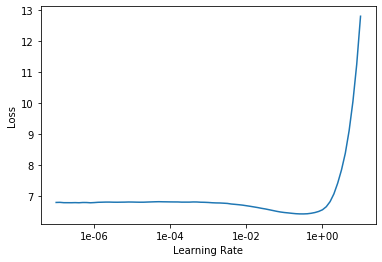

In [43]:
learn_twitter = language_model_learner(twitter_lm, AWD_LSTM, drop_mult=0.5) # define learner object
learn_twitter.lr_find(start_lr=1e-8, end_lr=1e2)
learn_twitter.recorder.plot()

In [44]:
learn_twitter.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.082162,4.748498,0.197657,05:42


In [45]:
learn_twitter.unfreeze()
learn_twitter.fit_one_cycle(cyc_len=4, max_lr=1e-3, moms=(0.8, 0.7))

learn_twitter.save_encoder('ft_enc_kaggle_v1')

epoch,train_loss,valid_loss,accuracy,time
0,4.628959,4.367979,0.240582,05:48
1,4.435961,4.226459,0.248637,05:49
2,4.274934,4.178045,0.253772,05:48
3,4.168681,4.174971,0.254271,05:48


In [0]:
pickle.dump(twitter_lm.train_ds.vocab, open('vocab.pkl','wb')) #save the vocab from the training dataset to reload them into the textclassdatabunch
Vocab_load = pickle.load(open('vocab.pkl', 'rb'))

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.539084,0.484590,0.769988,03:03


epoch,train_loss,valid_loss,accuracy,time
0,0.459895,0.413262,0.810987,02:50


epoch,train_loss,valid_loss,accuracy,time
0,0.447727,0.402925,0.818121,03:10
1,0.422125,0.386560,0.825446,03:04
2,0.381860,0.389372,0.825303,02:57


epoch,train_loss,valid_loss,accuracy,time
0,0.380041,0.385152,0.826968,03:22
1,0.367529,0.382735,0.827705,03:38
2,0.355834,0.385572,0.828966,03:36


col_0,0,1,2
row_0,,,
0,18181,146,3939
1,92,269,33
2,2956,26,16408


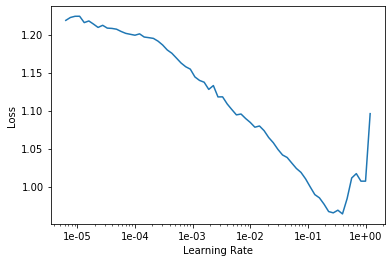

In [47]:
data_clas = TextClasDataBunch.from_csv('/content/', 'kaggle_train_sub_v2.csv', vocab=Vocab_load, min_freq=7, bs=64)
data_clas.save()
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc_kaggle_v1')
learn.freeze()

    #Find Optimum Learning Rate
learn.lr_find(start_lr=1e-6, end_lr=1e2)
learn.recorder.plot()

    #Train the Classifier by Gradually Unfreezing the Layers
learn.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))
    #Unfreeze Layer
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2.6,5e-3), moms=(0.8,0.7))
    #Unfreeze Layer
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(1e-5,5e-3), moms=(0.8,0.7))
    #Unfreeze All Layers
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-5,1e-3), moms=(0.8,0.7))
    # get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)


In [48]:
test.head()
test['pred_sentiment_kaggle'] = test['text'].apply(lambda row: str(learn.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(test['airline_sentiment'], test['pred_sentiment_kaggle']))


Test Accuracy:  0.8351548269581056


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# References:


https://arxiv.org/pdf/1801.06146.pdf
https://arxiv.org/abs/1506.01186
https://towardsdatascience.com/transfer-learning-in-nlp-for-tweet-stance-classification-8ab014da8dde
https://docs.fast.ai/train.html
https://github.com/fastai/fastai/tree/050080be574cb1260462bbd03e9600e43e7a54b1
